# XGBoost
##### Sean Wade

XGBoost is a modifed and optimized version of gradient boosted decision trees that is dominating machine learning competions.  Its strengths over regular gradient boosting are:
- Incorperates regularization
- Uses the objective function itself for the splitting criterion
- Approximates the loss nicelly with a newtonian quadratic

In [2]:
from __future__ import division, print_function
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
import xgboost as xgb
import time

from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.ccs').read())

## The Data

The goal of this dataset is predicting if breast cancer is malignant or benign.

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - class:
                - WDBC-Malignant
                - WDBC-Benign

In [5]:
breast_cancer = load_breast_cancer()

In [85]:
data, labels = breast_cancer['data'], breast_cancer['target']
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)

## Vanilla Model

In [8]:
data_train = xgb.DMatrix(x_train, label=y_train, feature_names=breast_cancer['feature_names'])
data_test = xgb.DMatrix(x_test, label=y_test, feature_names=breast_cancer['feature_names'])

params = {'bst:max_depth':2, 
         'bst:eta':1, 
         'silent':1, 
         'objective':'binary:logistic',
         'eval_metric':'auc'}

eval_list = {data_test:'eval', data_train:'train'}

In [9]:
# Training
bst = xgb.train(params, data_train, num_boost_round=10, evals_result=eval_list)
bst.save_model('0001.model')

In [10]:
y_hat = bst.predict(data_test)
y_hat[y_hat > .5] = 1
y_hat[y_hat <= .5] = 0
accuracy_score(y_hat, y_test)

0.95321637426900585

In [11]:
# Or using sklearn syntax
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9707602339181286

## Visualizing Results

The benifit of ensambling random forrests is that we can see exactly what the model is learning.  From the plot bellow we can see which features are most important to the trees.  We can also see an example decision tree that was learned and follwo the classification proccess.

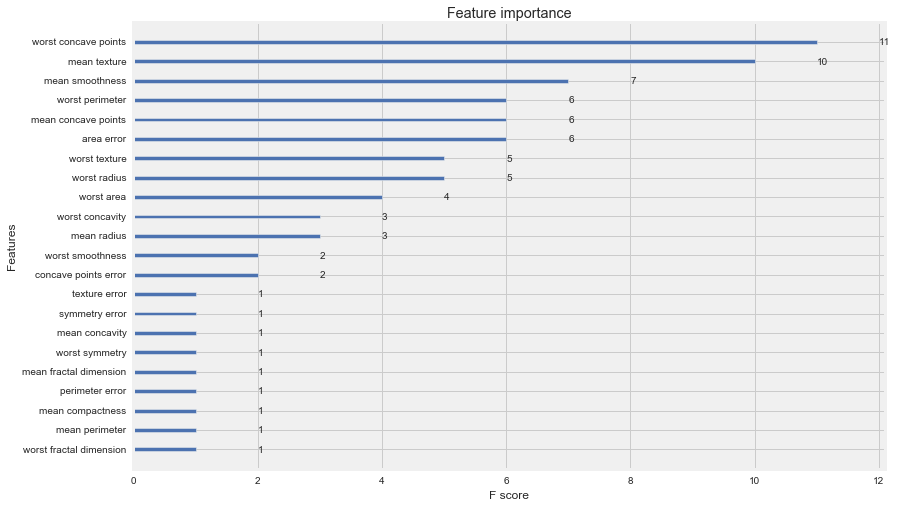

In [14]:
f, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(bst, ax=ax)
plt.show()

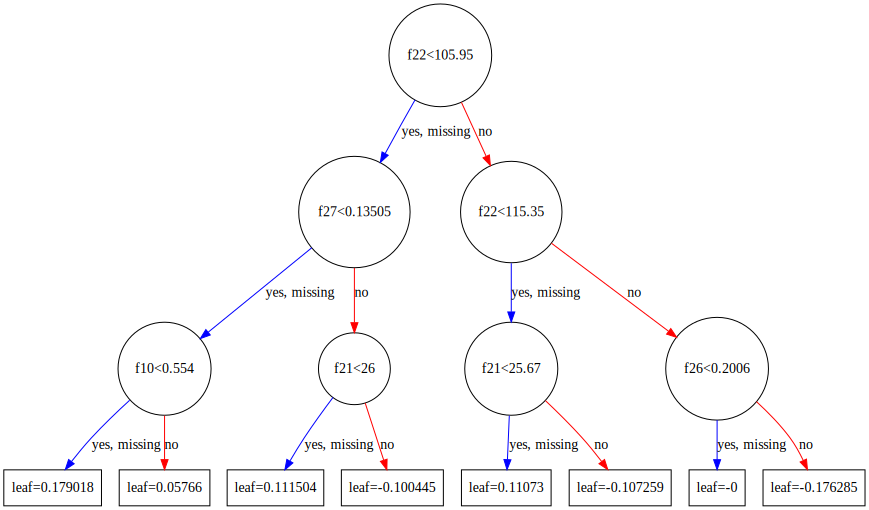

In [15]:
xgb.to_graphviz(model, num_trees=1, rankdir='UT')

## Adjusting Hyperparameters

In [158]:
def gridSearch(cv_params):
    ind_params = {'n_estimators': 1000, 'seed':0, 'objective': 'binary:logistic'}
    gs = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params) 
    return gs.fit(data, labels)

In [123]:
def gridResults(gs):
    sort_idx = np.argsort(gs.cv_results_['mean_test_score'])[::-1]
    params = np.array(gs.cv_results_["params"])[sort_idx]
    train_time = gs.cv_results_["mean_fit_time"][sort_idx]
    acc = gs.cv_results_["mean_test_score"][sort_idx]
    table = []
    for i in range(len(params)):
         table.append(['%.3f' % acc[i], '%.4f' % train_time[i], params[i]])
    print(tabulate(table, headers=['Accuracy', 'Time', 'Parameters']))

In [161]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
gs = gridSearch(cv_params)
gridResults(gs)

  Accuracy    Time  Parameters
----------  ------  ---------------------------------------
     0.972  0.4908  {'max_depth': 7, 'min_child_weight': 1}
     0.972  0.4777  {'max_depth': 3, 'min_child_weight': 1}
     0.967  0.5043  {'max_depth': 5, 'min_child_weight': 1}
     0.967  0.3554  {'max_depth': 3, 'min_child_weight': 3}
     0.965  0.4208  {'max_depth': 7, 'min_child_weight': 3}
     0.965  0.4071  {'max_depth': 5, 'min_child_weight': 3}
     0.96   0.3684  {'max_depth': 7, 'min_child_weight': 5}
     0.96   0.3561  {'max_depth': 5, 'min_child_weight': 5}
     0.96   0.3256  {'max_depth': 3, 'min_child_weight': 5}


In [162]:
cv_params = {'max_depth': [3,5,7], 'gamma':[i/10.0 for i in range(4,7)]}
gs = gridSearch(cv_params)
gridResults(gs)

  Accuracy    Time  Parameters
----------  ------  ------------------------------
     0.965  0.9165  {'max_depth': 7, 'gamma': 0.4}
     0.965  0.9073  {'max_depth': 5, 'gamma': 0.4}
     0.963  0.907   {'max_depth': 7, 'gamma': 0.6}
     0.963  0.9356  {'max_depth': 5, 'gamma': 0.6}
     0.963  0.7708  {'max_depth': 3, 'gamma': 0.4}
     0.96   0.9439  {'max_depth': 7, 'gamma': 0.5}
     0.96   0.7383  {'max_depth': 3, 'gamma': 0.5}
     0.958  0.8824  {'max_depth': 5, 'gamma': 0.5}
     0.956  0.8418  {'max_depth': 3, 'gamma': 0.6}


In [165]:
cv_params = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gs = gridSearch(cv_params)
gridResults(gs)

  Accuracy    Time  Parameters
----------  ------  -------------------------------------------
     0.975  0.3775  {'subsample': 0.6, 'colsample_bytree': 0.9}
     0.975  0.3736  {'subsample': 0.6, 'colsample_bytree': 0.8}
     0.975  0.3824  {'subsample': 0.7, 'colsample_bytree': 0.7}
     0.975  0.3695  {'subsample': 0.6, 'colsample_bytree': 0.7}
     0.975  0.3788  {'subsample': 0.9, 'colsample_bytree': 0.6}
     0.975  0.376   {'subsample': 0.7, 'colsample_bytree': 0.6}
     0.974  0.3978  {'subsample': 0.9, 'colsample_bytree': 0.8}
     0.974  0.3753  {'subsample': 0.9, 'colsample_bytree': 0.7}
     0.972  0.3849  {'subsample': 0.9, 'colsample_bytree': 0.9}
     0.972  0.3821  {'subsample': 0.7, 'colsample_bytree': 0.9}
     0.972  0.3929  {'subsample': 0.7, 'colsample_bytree': 0.8}
     0.972  0.3757  {'subsample': 0.8, 'colsample_bytree': 0.7}
     0.972  0.373   {'subsample': 0.6, 'colsample_bytree': 0.6}
     0.97   0.38    {'subsample': 0.8, 'colsample_bytree': 0.8}
     0.97

In [167]:
cv_params = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'gamma':[i/10.0 for i in range(4,7)]
}
gs = gridSearch(cv_params)
gridResults(gs)

  Accuracy    Time  Parameters
----------  ------  ----------------------------------
     0.963  0.7058  {'reg_alpha': 0.01, 'gamma': 0.5}
     0.963  0.6792  {'reg_alpha': 0.1, 'gamma': 0.4}
     0.963  0.6959  {'reg_alpha': 0.01, 'gamma': 0.4}
     0.963  0.6978  {'reg_alpha': 1e-05, 'gamma': 0.4}
     0.96   0.7748  {'reg_alpha': 1, 'gamma': 0.5}
     0.96   0.7429  {'reg_alpha': 1e-05, 'gamma': 0.5}
     0.96   0.7494  {'reg_alpha': 1, 'gamma': 0.4}
     0.958  0.7635  {'reg_alpha': 1, 'gamma': 0.6}
     0.958  0.7137  {'reg_alpha': 0.1, 'gamma': 0.6}
     0.958  0.7104  {'reg_alpha': 0.01, 'gamma': 0.6}
     0.958  0.9118  {'reg_alpha': 0.1, 'gamma': 0.5}
     0.956  0.6965  {'reg_alpha': 1e-05, 'gamma': 0.6}
     0.905  0.6728  {'reg_alpha': 100, 'gamma': 0.4}
     0.889  0.7735  {'reg_alpha': 100, 'gamma': 0.6}
     0.889  0.683   {'reg_alpha': 100, 'gamma': 0.5}


### Analysis

Based on a cross-validation with depth and min child weight I can determin that having a lower min child rate is definatly the best parameter.  The max depth on the other hand seems to vary around 5 and 7.  Subsamples should be lower and pick the regularization to be .01 and .5 for gamma.

## Comparison

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [106]:
def testModel(model, data, labels, num_tests=3):
    ''' Tests a model for comparison by averaging results.
    Args:
      model: sklearn model
      data : dataset
      lables : lables
      num_tests : number of times to average
    
    Returns:
      avg_score : the average model score
      avg_time : the average training time
    '''
    
    scores = []
    train_times = []
    for _ in range(num_tests):
        x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)
        start = time.time()
        model.fit(x_train, y_train)
        stop = time.time()
        train_times.append(stop - start)
        scores.append(model.score(x_test, y_test))
        
    return np.mean(scores), np.mean(train_times)


model_list = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    xgb.XGBClassifier()
]

model_names = [
    'Logistic Regression',
    'KNN',
    'Descision Tree',
    'Random Forrests',
    'Gradient Boosting',
    'XGBoost'
]

score_list = []
time_list = []

for model in model_list:
    score, train_time = testModel(model, data, labels)
    score_list.append(score)
    time_list.append(train_time)
    
print(tabulate([[x,y,z] for x,y,z in zip(model_names, score_list, time_list)],
               headers=['Model', 'Accuracy', 'Time']))

Model                  Accuracy         Time
-------------------  ----------  -----------
Logistic Regression    0.929825  0.00407298
KNN                    0.94152   0.000410636
Descision Tree         0.920078  0.00398469
Random Forrests        0.953216  0.0293946
Gradient Boosting      0.949318  0.124868
XGBoost                0.97076   0.0795629


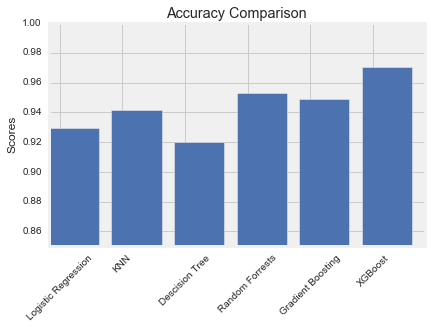

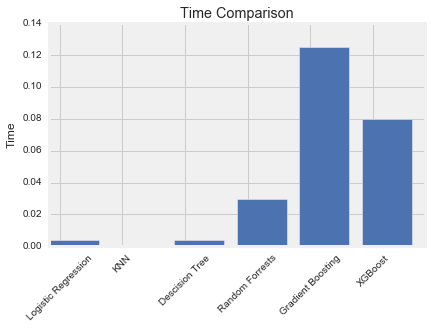

In [107]:
# Plot Results
f, ax = plt.subplots()
ind = np.arange(len(score_list))
bar_1 = ax.bar(ind, score_list)
ax.set_ylabel('Scores')
ax.set_title('Accuracy Comparison')
ax.set_xticks(ind + .35 / 2)
ax.set_xticklabels(model_names, rotation=45)
plt.ylim(.85,1)
plt.show()

f, ax = plt.subplots()
ind = np.arange(len(time_list))
bar_1 = ax.bar(ind, time_list)
ax.set_ylabel('Time')
ax.set_title('Time Comparison')
ax.set_xticks(ind + .35 / 2)
ax.set_xticklabels(model_names, rotation=45)
plt.show()

### Results

It was very interesting to compare all these models.  As far as accuary goes, all the tree based ensemble methods dominated.  XGBoost was the clear winner with a single decision tree being the worst performing.  The time it took to train the trees was definatly the longest.  It was interesting to see that although gradient boosting was worse than XGBoost, it still took twice as long to train.

## Extra Credit

In [33]:
scores = []
for _ in range(10):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)
    #x_train = preprocessing.scale(x_train)
    #x_test = preprocessing.scale(x_test)
    
    params = {'n_estimators': 1000, 
          'subsample': 0.6,
          'colsample_bytree': .9,
          'gamma': .4,
          'reg_alpha': .01,
          'max_depth': 7,
          'objective': 'binary:logistic'}
    
    model = xgb.XGBClassifier(**params)
    model.fit(x_train, y_train)
    scores.append(model.score(x_test, y_test))
    
print("Accuracy: %.3f" % np.mean(scores))

Accuracy: 0.971


In [90]:
scores = []

data = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])

for _ in range(10):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)
    x_train = np.log10(x_train)
    x_test = np.log10(x_test)
    
    params = {'n_estimators': 1000, 
          'subsample': 0.6,
          'colsample_bytree': .9,
          'gamma': .4,
          'reg_alpha': .01,
          'max_depth': 7,
          'objective': 'binary:logistic'}
    
    model = xgb.XGBClassifier(**params)
    model.fit(x_train, y_train)
    scores.append(model.score(x_test, y_test))
    
print("Accuracy: %.3f" % np.mean(scores))

Accuracy: 0.975


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
